## Optical flow control

In a biological study on honeybee landing, [1], Srinivasan et al. showed that honeybees keep optical flow constant while landing. Specifically, they showed that during a grazing landing, the ratio between the honeybees' horizontal speed and their height was a constant for most of the trajectory. We will call this a constant _ventral flow_ landing. Later, robotic studies generalized the idea of constant optical flow landings to straight vertical landings, in which case the _divergence_ in a downward looking camera was kept constant [2,3]. Later, it was shown that honeybees indeed keep the divergence constant during vertical landings [4].

In this notebook, we will look at how easy it is to _control_ a constant optical flow landing. This will illustrate some of the fundamental challenges of using optical flow observables for control.


## Lander model

We will employ an extremely simple lander model as used in [5]. This model only focuses on a single axis, representing a 'drone' that moves only vertically. Below, we will explain this model, using the formulas and figures of [5].

We will use the following state space model:

__(Eq. 1)__ $\quad \dot{\mathbf{x}}(t) = A \mathbf{x}(t) + B \mathbf{u}(t)$,

where the state vector $\mathbf{x}= [z(t), v_z(t)]^{T}$, and $\mathbf{u}(t) = u_z(t)$, so that:

$\begin{bmatrix} \dot{z}(t) \\ \dot{v_z}(t) \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix} \begin{bmatrix} z(t) \\ v_z(t) \end{bmatrix} + \begin{bmatrix} 0 \\ 1 \end{bmatrix} u_z(t)$

This model assumes that $u_z$ = $a_z$, implying that any possible gravity is taken care of by the $u_z$-term:
$a_z = -g + \frac{u_z'}{m} = u_z$, where $u_z' = m (a_z + g)$ is the actual upward thrust generated by the robot in Newton. Although [5] goes on to include drag, in this exercise we will leave it out for simplicity.

Below, we see the axis system as used in this exercise. Both the $z$ and $v_z$ axes are positive up. The drone has a downward looking camera. When the drone goes down, it will see an expanding flow field, i.e., with positive divergence $D$. In this exercise, we will not use the divergence itself, but the relative vertical velocity $\vartheta_z = \frac{v_z}{z} = -D$ as the optical flow observable to control. This relative velocity is the negative of divergence and hence is also zero when the drone is not moving and constant when the divergence is constant. 


<CENTER>
<IMG SRC="axes_system.png" WIDTH="300" ALT="Axes system used in the optical flow control exerise."></IMG>
<small>Figure 1 from [5]: Axis system used in the exercise. </small>
</CENTER>

The control law followed by the drone will be also very simple:

$u_z = K_z (\vartheta_z^{*} - \vartheta_z)$,

i.e., a simple proportional gain controller.

## Perfect measurements
Let us now see how difficult it is to control a constant divergence landing when the lander perfectly perceives the divergence. We will use functions from the Python script `exercise_landing_python.py` <A HREF="https://github.com/guidoAI/optic_flow_control_notebook/blob/master/exercise_landing_python.py" TARGET="_blank">(link to file)</A>. Specifically, we will simulate the state space model from Eq. 1, where the lander is continuously sensing the relative velocity without any delay (functions `continuous_control` and `f_continuous`). In the controller, the relative velocity is directly set to `(x[1] / x[0])`, i.e., the velocity divided by the height. Running the script below should show quite a nice constant divergence landing, with just a small deviation from the desired $\vartheta_z$ at the onset of the landing. 

<font color='red'><B>Exercise 1.</B></font>

1. Play around with the gain (`OFL.P`). What happens to the error in the relative velocity? Can you make the error really big? Can you make the drone crash? If yes, how?
2. Play around with the basic simulation time step (`OFL.dt`). Does it change anything?
3. Try various initial conditions (`OFL.x0`) and desired relative velocities. What happens to the error in the relative velocity? Can you make it really big?


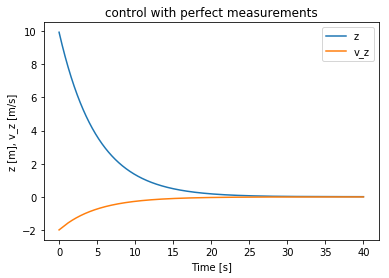

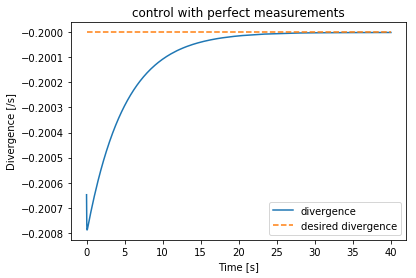

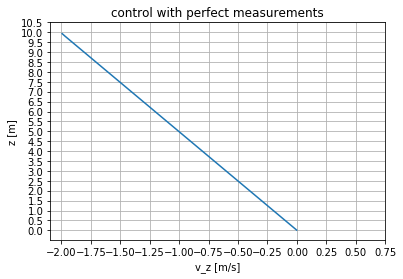

In [12]:
%matplotlib inline
import exercise_landing_python as OFL
import numpy as np

# ********************
# THINGS TO PLAY WITH:
# ********************

# state x = [height, vertical velocity]
OFL.x0 = [10.0, -2.0]
# desired divergence = the desired (velocity / height)
OFL.desired_div = OFL.x0[1] / OFL.x0[0]; # should not be called div but relvel
OFL.P = 500;
OFL.dt = 0.033;

# ************************
# THINGS NOT TO PLAY WITH:
# ************************

# global variables:
OFL.n_states = 2;
OFL.t0 = 0;
OFL.t1 = 40;
OFL.time_steps = np.arange(OFL.t0, OFL.t1, OFL.dt);
OFL.n_time_steps = len(OFL.time_steps);

# control with perfect measurements:
states_over_time = OFL.continuous_control();
OFL.plot_states_over_time(states_over_time, OFL.time_steps, plot_title='control with perfect measurements')



## Digital sampling and control

Now, we will look at what happens when the drone will have a digital controller. It still measures the relative velocity perfectly, but now the control will stay constant for the duration of the time step `OF.dt`. This zero-order hold is implemented in the functions `control_with_ZOH` and `f_ZOH`. 

<font color='red'><B>Exercise 2.</B></font>

1. The zero-order-hold leads to a different phenomenon during landing than with perfect and timely measurements. What do you observe? Why do you think this happens? Shorten the time span of the simulation, so that the huge peak in relative velocity just disappears.

2. What happens when you make the control gain smaller or bigger? Can you delay or quicken the point at which oscillations occur?

3. What happens when you make the time step smaller or bigger? Can you delay or quicken the point at which oscillations occur?


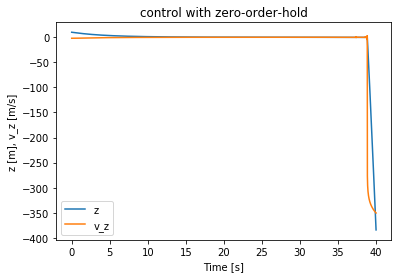

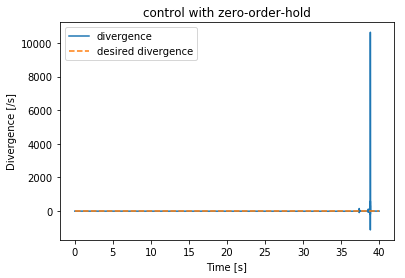

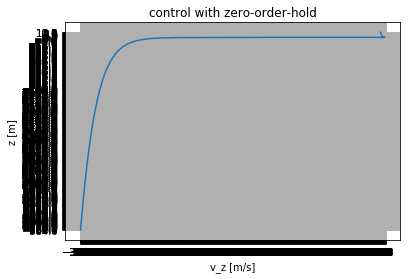

In [18]:
# ********************
# THINGS TO PLAY WITH:
# ********************

# state x = [height, vertical velocity]
OFL.x0 = [10.0, -2.0]
# desired divergence = the desired (velocity / height)
OFL.desired_div = OFL.x0[1] / OFL.x0[0]; # should not be called div but relvel
OFL.P = 15;
OFL.dt = 0.001;
OFL.t1 = 40;

# ************************
# THINGS NOT TO PLAY WITH:
# ************************

# global variables:
OFL.n_states = 2;
OFL.t0 = 0;
OFL.time_steps = np.arange(OFL.t0, OFL.t1, OFL.dt);
OFL.n_time_steps = len(OFL.time_steps);

# control with ZOH:
states_over_time = OFL.control_with_ZOH();
OFL.plot_states_over_time(states_over_time, OFL.time_steps, plot_title='control with zero-order-hold')


## Control with delay

In the exercise above, we already saw that even a tiny delay as caused by digital sampling is sufficient to lead to optical flow control problems. Normally, a vision process has more delay than the delay caused by sampling. On a robot, capturing an image, sending it to a processor, performing optical flow algorithms, and then extracting the relative velocity from the flow, all takes extra time. This results in an additional delay. Also animals such as honeybees are subject to delays when perceiving optical flow. 

In the script below, we introduce an additional delay in the system, as implemented in the function `control_with_delay`. The actuation is still a zero-order hold, the measurements are still 'perfect', but now the measurements are also delayed for a certain number of time steps.

<font color='red'><B>Exercise 3.</B></font>

1. What are the differences you see with the ZOH-only case - for identical initial conditions?

2. Can you change the parameters below to get a better constant divergence landing without oscillations? Can you set the parameters such that you get a completely smooth landing? 

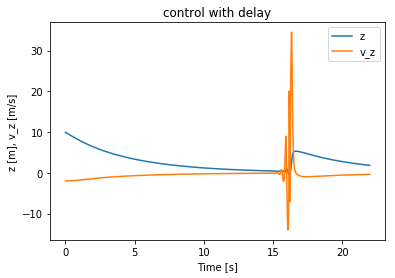

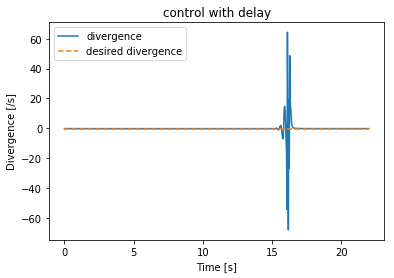

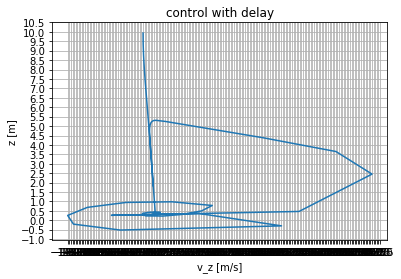

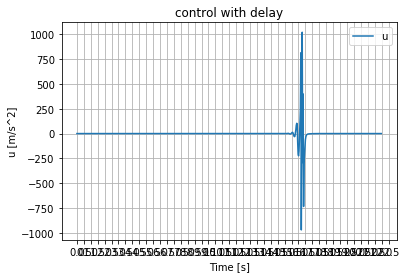

In [20]:
# ********************
# THINGS TO PLAY WITH:
# ********************

# state x = [height, vertical velocity]
OFL.x0 = [10.0, -2.0]
# desired divergence = the desired (velocity / height)
OFL.desired_div = OFL.x0[1] / OFL.x0[0]; # should not be called div but relvel
OFL.P = 15;
OFL.dt = 0.033;
OFL.t1 = 22;
n_time_steps_delay = 2;

# ************************
# THINGS NOT TO PLAY WITH:
# ************************

# global variables:
OFL.n_states = 2;
OFL.t0 = 0;
OFL.time_steps = np.arange(OFL.t0, OFL.t1, OFL.dt);
OFL.n_time_steps = len(OFL.time_steps);

# control with delay:
states_over_time, u = OFL.control_with_delay(time_steps_delay = n_time_steps_delay);
OFL.plot_states_over_time(states_over_time, OFL.time_steps, plot_title='control with delay', u=u)

## Instability-based approach to optical-flow-based distance estimation

From the lander model of Eq. 1 it is obvious that the instability that arises towards the end of landing is _self-induced_ - there are simply no external factors in the model. The last exercise makes clear that in a system with delay, there will first be (growing) oscillations before the system actually becomes unstable. In [5], this phenomenon was noted explicitly and analyzed for the first time. Below, you can see the root locust plot of the zero-order hold system without delay.  

<CENTER>
<IMG SRC="ZOH.png" WIDTH="300" ALT="Root locust plot of the ZOH system."></IMG>
<small>Figure 2, from [5]: Root locust plot of the ZOH system. </small>
</CENTER>

The figure shows at what the critical gain $K_z$ is when the system gets unstable at two different heights, $z=1, 10$ m. In fact, a mathematical analysis of the poles of the system led to the following formula relating the height with the critical gain $K_z$: 

__(Eq. 2)__ $\quad K_z = \frac{2}{T}z$.

Hence, there is a linear relationship between the control gain $K_z$ and the height at which the system gets unstable. The 'bad' news is that whatever $K_z$ one may pick - even a very low one - there will be a height at which the drone will start to oscillate and get unstable. The fundamental reason for this is that close to the surface, $z$ is very low, and even small changes to $v_z$ will lead to very large changes in $\vartheta_z$. 

However, the observation that normally there are first growing oscillations led to an interesting idea: If the drone can detect these oscillations, it can actually estimate the height! In fact, when using a fixed gain, the oscillation detection can be used to trigger the final landing response. Drones can even use this concept in hover, as the drone can increase the gain until it starts to oscillate. This can be used to estimate height [5], but, more interestingly, it can also be used to select the ideal gain for a high-performance optical flow landing [6].


## References

[1] M.V. Srinivasan, S.W. Zhang, M. Lehrer, and S. Collett, Honeybee navigation en route to the goal: visual flight control and odometry. The Journal of Experimental Biology 199, 237–244 (1996).

[2] B. Hérissé, T. Hamel, R. Mahony, and F.-X. Russotto. Landing a VTOL Unmanned Aerial  Vehicle on a moving platform using optical  flow. IEEE Transactions on Robotics, 28(1):77–89, 2012.

[3] Izzo, D., and de Croon, G.C.H.E. (2012). Landing with time-to-contact and ventral optic flow estimates. Journal of Guidance, Control, and Dynamics, 35(4), 1362-1367.

[4] E. Baird, N. Boeddeker, M.R. Ibbotson, and M.V. Srinivasan. A universal strategy for visually guided landing. PNAS: Biological Sciences - Neuroscience, 2013.

[5] G.C.H.E. de Croon (2016). Monocular distance estimation with optical flow maneuvers and efference copies: a stability-based strategy. Bioinspiration & biomimetics, 11(1), 016004.

[6] Ho, H.W., de Croon, G.C.H.E., van Kampen, E., Chu, Q.P., & Mulder, M. (2016). Adaptive control strategy for constant optical flow divergence landing. Accepted in IEEE Transactions on Robotics.


## Answers

Exercise 1.

1. A higher P leads to an even lower error. A low P can lead to high errors, or even a crash. For instance, a value of 0.1 or 0.01 leads to very bad control results.

2. Changing dt has no substantial effects.

3. Setting a high initial velocity, e.g., -10 m/s, can create a relatively big initial error, but the control will correct for it later during the landing.

Exercise 2.

1. With a t1 of, e.g., 22, we can observe that the divergence gets unstable towards the end of the run. Setting it to 20.5 makes the instability disappear.

2. A lower gain P delays the onset of instability. For example, a gain P of 5 will delay the instability to around t=25 seconds, while a gain P of 30 will give an instability around 18 seconds. 

3. A smaller time step will delay the onset of instability, e.g., with a dt of 0.015 it will happen at 25 seconds. A larger dt will lead to instability sooner, e.g., a dt of 0.07 will give an instability around 18 seconds.

Exercise 3.

1. For the same initial conditions, but with a delay of 2 time steps, the instability occurs much sooner. 

2. Setting the gain lower, the time step smaller, and the delay to 0 delay the onset of instability, but it will always occur.
